In [12]:
%matplotlib widget

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Params

In [14]:
WIDTH = 32

# Stimuli generation

In [15]:
images = []
for i in range(WIDTH):
    img = np.ones((1,WIDTH))
    img[0,i:i+2] = 0.0
    img[0,i+10:i+12] = 0.0
    images.append(img)

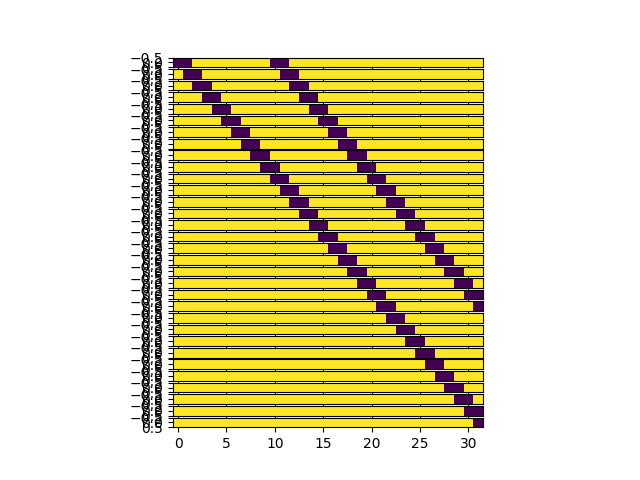

In [16]:
fig, axes = plt.subplots(WIDTH, sharex=True)
for i, a in zip(images, axes):
    a.imshow(i)


# High-pass filters

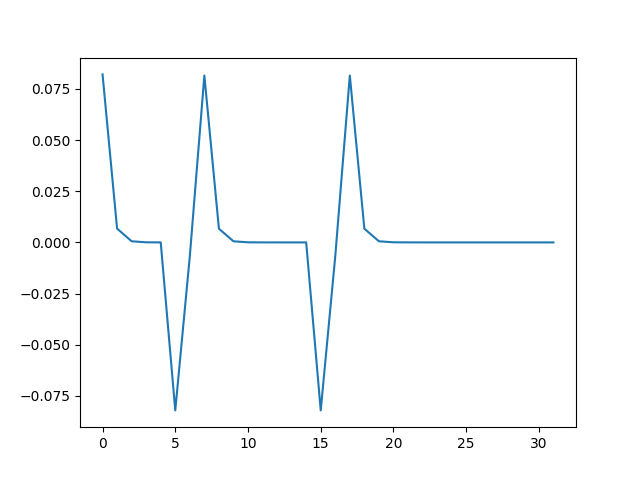

In [17]:
# Where is ESTMD
ESTMD_X = 16

LPF_TAU = 0.4

# EMA time constant
LPF_K = np.exp(-1 / LPF_TAU)

f = 0.0
fs = []
for t in range(WIDTH):
    inp = images[t][0,ESTMD_X]
    f = (LPF_K * f) + ((1.0 - LPF_K) * inp)
    fs.append(inp - f)

fig, axis = plt.subplots()
axis.plot(fs)

# Half-wave rectification

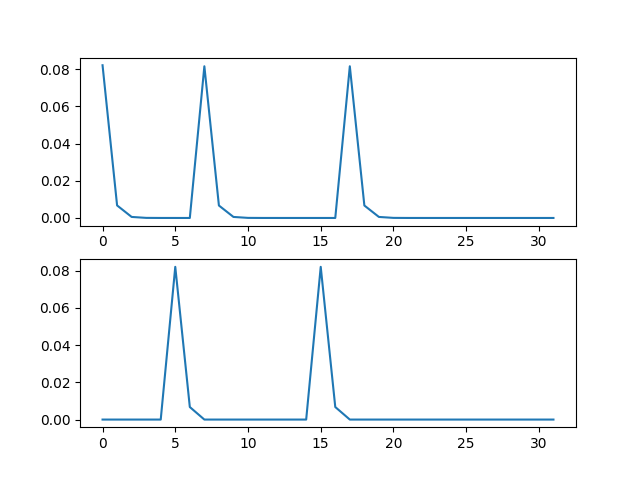

In [18]:
fs = np.asarray(fs)

on_f = np.maximum(fs, 0.0)
off_f = -np.minimum(fs, 0.0)

fig, axes = plt.subplots(2)
axes[0].plot(on_f)
axes[1].plot(off_f)

# FDSR

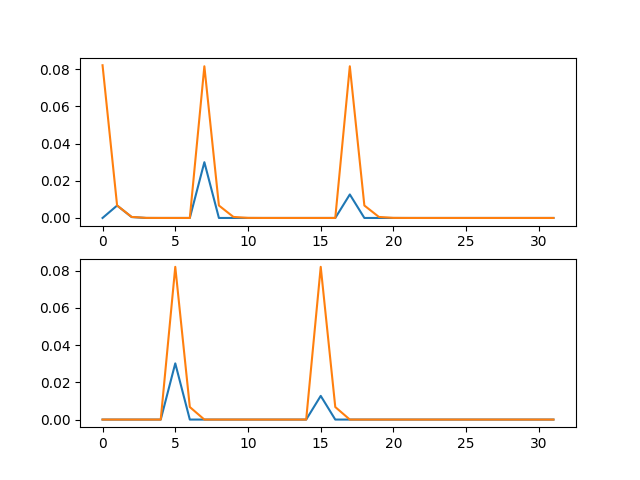

In [19]:
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 100

FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

a_on = 0.0
a_off = 0.0
a_ons = [0.0]
a_offs = [0.0]
for t in range(1, WIDTH):
    k_on = FSR_K_FAST if (on_f[t] - on_f[t - 1]) > 0.0 else FSR_K_SLOW
    k_off = FSR_K_FAST if (off_f[t] - off_f[t - 1]) > 0.0 else FSR_K_SLOW
    
    a_on = ((1.0 - k_on) * on_f[t]) + (k_on * a_on) 
    a_off = ((1.0 - k_off) * off_f[t]) + (k_off * a_off) 
    
    a_ons.append(max(0.0, on_f[t] - a_on))
    a_offs.append(max(0.0, off_f[t] - a_off))

fig, axes = plt.subplots(2)
axes[0].plot(a_ons)
axes[0].plot(on_f)
axes[1].plot(a_offs)
axes[1].plot(off_f)

# Recombine

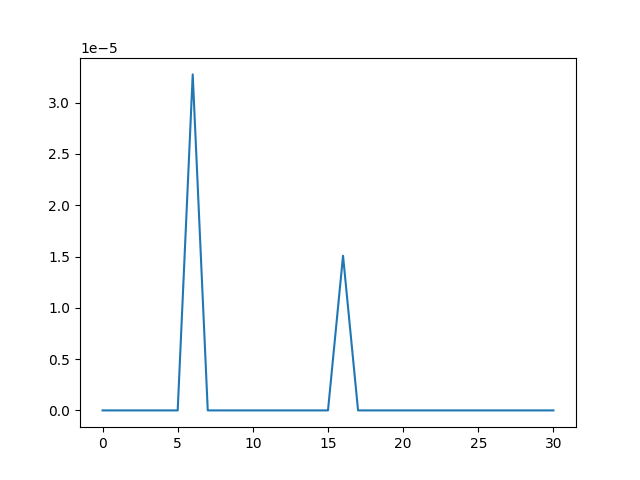

In [20]:
OFF_TAU = 25
OFF_K = np.exp(-1 / OFF_TAU)

off_filter = 0.0
off_filters = []
output = []
for t in range(1, WIDTH):
    off_filter = ((1.0 - OFF_K) * a_offs[t]) + (OFF_K * off_filter) 
    output.append(off_filter * a_ons[t])
    off_filters.append(off_filter)

fig, axis = plt.subplots()
axis.plot(output)